## Neural networks for segmentation

In [1]:
# !wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# !unzip -q data.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

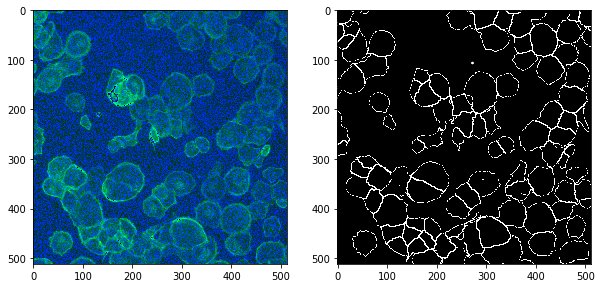

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('data/BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('data/BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [3]:
from PIL import Image
import numpy as np

img = np.asarray(Image.open('data/BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
mask = np.asarray(Image.open('data/BBBC018_v1_outlines/train/00735-cells.png'))[..., None]
print(img.shape, mask.shape)
stacked = np.concatenate([img, mask], axis=-1) / 255.
img.shape, mask.shape, stacked.shape

(512, 512, 3) (512, 512, 1)


((512, 512, 3), (512, 512, 1), (512, 512, 4))

In [4]:
img, target = stacked[..., :-1], stacked[..., -1:]

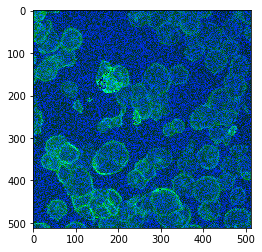

In [5]:
plt.imshow(img)

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [6]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [7]:
from torch import nn

class IoU(nn.Module):
    def forward(self, outputs, targets):
        preds = torch.argmax(outputs, axis=1)
        inter = ((preds > 0) & (targets > 0)).float().sum()
        union = ((preds > 0) | (targets > 0)).float().sum()

        return inter / union

In [8]:
import torch 
import torchvision
from time import time

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
SAVE_BEST = False
MODELS_DIR = 'models/'

In [10]:
@torch.no_grad()
def eval_model(model, dataloader, criterion, metric):
    total_loss = []
    metric_vals = []
    model.eval()

    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        total_loss.append(criterion(outputs, targets).item())
        metric_vals.append(metric(outputs, targets).item())

    return total_loss, metric_vals

def train_one_epoch(model, dataloader, criterion, optimizer, metric):
    # metric.reset('train')
    total_loss = []
    metric_val = []
    model.train(True)
    optimizer.zero_grad()

    step = 100
    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        loss = criterion(outputs, targets)
        metric_val.append(metric(outputs, targets).item())

        loss.backward()
    
        total_loss.append(loss.item())

    optimizer.step()
    optimizer.zero_grad()

    return total_loss, metric_val

In [11]:
from collections import defaultdict
import os

def train_model(model, dataloaders, criterion, optimizer, metric, model_name='', scheduler=None, epochs=10):
    loss_hist = defaultdict(list)
    metric_hist = defaultdict(list)
    epochs = epochs
    timer = time()
    max_val_metric = 0
    
    for epoch in range(epochs):
        losses, metrics = train_one_epoch(model, dataloaders['train'],
                                                criterion, optimizer, metric) 

        loss_hist['train'].append(np.mean(losses))
        metric_hist['train'].append(np.mean(metrics))

        val_losses, val_metrics = eval_model(model, dataloaders['val'], criterion, metric)

        loss_hist['val'].append(np.mean(val_losses))
        metric_hist['val'].append(np.mean(val_metrics))

        print("Epoch [{}/{}] Time: {:.2f}s; Loss: {:.4f}; IoU: {:.4f}; ValLoss: {:.4f}; ValIoU: {:.4f}".format(
                epoch + 1, epochs, time() - timer,
                loss_hist['train'][-1],
                metric_hist['train'][-1],
                loss_hist['val'][-1],
                metric_hist['val'][-1])
        )
        

        if SAVE_BEST and model_name and metric_hist['val'][-1] > max_val_acc:
            max_val_acc = metric_hist['val'][-1]
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, '{}.path'.format(model_name)))
        
        # if sum(acc_hist['val'][-2:])/2 > args.stop_accuracy:
        #     break
        if scheduler is not None:
            scheduler.step()
        timer = time()

    return model, loss_hist, metric_hist

In [12]:
from dataset import ImgDataset

In [13]:
from torchvision.transforms import RandomAffine
import numpy as np
from PIL import Image

class RandomAffineSeg(RandomAffine):
    def __call__(self, img):

        ret = self.get_params(self.degrees, self.translate, self.scale, self.shear, img.size)
        img = np.asarray(img)
        img, mask = Image.fromarray(img[..., :-1]), Image.fromarray(img[..., -1])
        
        img = F.affine(img, *ret, resample=self.resample, fillcolor=self.fillcolor)
        mask = F.affine(mask, *ret, resample=self.resample, fillcolor=self.fillcolor)

        return Image.fromarray(np.concatenate([np.asarray(img), np.asarray(mask)[..., None]], axis=-1))

In [14]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

BASE_IMGS_DIR = 'data/BBBC018_v1_images-fixed' 
BASE_MASKS_DIR = 'data/BBBC018_v1_outlines'

TRAIN_IMG_DIR = os.path.join(BASE_IMGS_DIR , 'train')
TRAIN_MASK_DIR = os.path.join(BASE_MASKS_DIR, 'train')

VAL_IMG_DIR = os.path.join(BASE_IMGS_DIR , 'val')
VAL_MASK_DIR = os.path.join(BASE_MASKS_DIR, 'val')

TEST_IMG_DIR = os.path.join(BASE_IMGS_DIR , 'test')


def get_dataloaders(batch_size=20, val_size=0.2,
                    num_workers=1, shuffle=True):
    # logging.info("Batch size %d" %batch_size)
    data_transform = {
        "train": transforms.Compose([
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomVerticalFlip(),
#                 transforms.Pad(512, padding_mode='reflect'),
#                 transforms.Pad(512, padding_mode='symmetric'),
#                 RandomAffineSeg(degrees=90, scale=(0.8, 1.1), resample=Image.NEAREST),
#                 transforms.RandomCrop(512, padding=512, pad_if_needed=True, padding_mode="reflect"),
                # transforms.Resize((512, 512)),
                transforms.ToTensor()
                ]),
        "test": transforms.Compose([
                # transforms.Resize((512, 512)),
                transforms.ToTensor(),
                ])
    }
    
    datasets = {
        "train": ImgDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, data_transform['train']),
        "val": ImgDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=data_transform['test']),
        "test": ImgDataset(TEST_IMG_DIR, transform=data_transform['test']),
        }
    
    dataloaders = {
        "train": DataLoader(datasets['train'], shuffle=shuffle, 
                            batch_size=batch_size),
        "val": DataLoader(datasets['val'], shuffle=False, 
                            batch_size=batch_size, num_workers=num_workers),
        "test": DataLoader(datasets['test'], shuffle=False, 
                            batch_size=batch_size, num_workers=num_workers),
        }

    return dataloaders

In [15]:
def plot_pil(img):
    print(img.shape)
    if len(img.shape) < 3:
        img = img.numpy()
    else: 
        img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img, 'gray')
    plt.show()

In [16]:
dataloaders = get_dataloaders(batch_size=10)
itt = iter(dataloaders['train'])

In [17]:

img, target = next(itt)
# plot_pil(img[0])
# plot_pil(target[0])

In [18]:
target.shape

torch.Size([10, 1, 512, 512])

In [19]:
from torch import nn

def conv(cin, cout, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(cout),
    )

def deconv(cin, cmid, cout, kernel_size=3, padding=1, stride=2):
    return nn.Sequential(
        nn.Conv2d(cin, cmid, kernel_size, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(cmid),
        nn.ConvTranspose2d(cmid, cout, kernel_size, stride=stride,
                         padding=padding, output_padding=1)
    )

class UNet(nn.Module):
    def __init__(self, cin=3, base=16):
        super(UNet, self).__init__()
        pool_kernel = 2
        self.conv1 = conv(cin, base) # 512x512xC -> 512x512x16
        self.pool1 = nn.MaxPool2d(pool_kernel) # -> 256x256x16
        
        self.conv2 = conv(base, base*2) # -> 256x256x32
        self.pool2 = nn.MaxPool2d(pool_kernel) # -> 128x128x32

        self.conv3 = conv(base*2, base*4) # -> 128x128x64
        self.pool3 = nn.MaxPool2d(pool_kernel) # -> 64x64x64
        
        # self.conv4 = conv(base*4, base*8) # -> 64x64x128
        # self.pool4 = nn.MaxPool2d(pool_kernel) # -> 32x32x128

        self.deconv1 = nn.ConvTranspose2d(base*4, base*2, kernel_size=3, stride=2, padding=1, output_padding=1) # 32x32x128 -> 64x64x64

        # ## concat -- 64x64x128
        # self.deconv2 = deconv(base*8, base*4, base*2) # 64x64x128 -> 64x64x64 -> 128x128x32
        # ## concat -- 128x128x64
        self.deconv3 = deconv(base*4, base*2, base) # 128x128x64 -> 128x128x32 -> 256x256x16
        ## concat -- 256x256x32
        self.deconv4 = deconv(base*2, base, base) # 256x256x32 -> 256x256x16 -> 512x512x2
        self.conv5 = nn.Conv2d(base, 1, kernel_size=1)
        self.softmax = nn.Sigmoid()


    def forward(self, input):
        branch1 = self.pool1(self.conv1(input))
        branch2 = self.pool2(self.conv2(branch1))
        branch3 = self.pool3(self.conv3(branch2))
        # branch4 = self.pool4(self.conv4(branch3))
        output = self.deconv1(branch3)
        # return output
        output = torch.cat([output, branch2], dim=1)
        # output = torch.cat([self.deconv2(output), branch2], dim=1)
        output = torch.cat([self.deconv3(output), branch1], dim=1)

        output = self.deconv4(output)
        output = self.conv5(output)
        
        return self.softmax(output)



In [20]:
model = UNet()
model

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (de

In [21]:
res = model(img)

In [22]:
res.shape

torch.Size([10, 1, 512, 512])

In [23]:
target.shape

torch.Size([10, 1, 512, 512])

In [28]:
IoU()(res, target)

tensor(0.0426)

In [27]:
a = torch.tensor([[1, 1, 1],
                [0, 0, 0]])
b = torch.tensor([[1, 0, 1],
                [0, 0, 0]])
class IoU(nn.Module):
    def forward(self, outputs, targets):
        preds = outputs > 0.5
#         b, c, h, w = preds.shape
#         preds = preds.reshape(b, h, w) 
        inter = (preds & (targets > 0)).float().sum()
        union = (preds | (targets > 0)).float().sum()

        return inter / union

# IoU()(a, b)

In [29]:
class MSELoss2(nn.Module):
    def forward(self, outputs, targets):
        return nn.BCELoss()(outputs, targets.float())

In [55]:
def run_training(epochs=10):
    model = UNet(base=16)
    model = model.to(device)

    criterion = MSELoss2()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    metric = IoU()
    dataloaders = get_dataloaders(batch_size=5, num_workers=4)
    print("Run Training")
    train_model(model, dataloaders, criterion, optimizer, metric, epochs=epochs)

    return model

In [57]:
model = run_training(50)

Run Training
Epoch [1/50] Time: 2.96s; Loss: 0.6581; IoU: 0.0339; ValLoss: 0.6588; ValIoU: 0.0001
Epoch [2/50] Time: 3.05s; Loss: 0.6537; IoU: 0.0494; ValLoss: 0.6614; ValIoU: 0.0536
Epoch [3/50] Time: 2.90s; Loss: 0.6501; IoU: 0.0645; ValLoss: 0.6633; ValIoU: 0.0646
Epoch [4/50] Time: 2.89s; Loss: 0.6470; IoU: 0.0828; ValLoss: 0.6663; ValIoU: 0.0882
Epoch [5/50] Time: 2.89s; Loss: 0.6441; IoU: 0.0971; ValLoss: 0.6720; ValIoU: 0.1073
Epoch [6/50] Time: 2.92s; Loss: 0.6421; IoU: 0.1008; ValLoss: 0.6693; ValIoU: 0.1126
Epoch [7/50] Time: 2.91s; Loss: 0.6401; IoU: 0.1035; ValLoss: 0.6584; ValIoU: 0.1152
Epoch [8/50] Time: 2.86s; Loss: 0.6377; IoU: 0.1055; ValLoss: 0.6662; ValIoU: 0.1141
Epoch [9/50] Time: 2.87s; Loss: 0.6352; IoU: 0.1141; ValLoss: 0.6637; ValIoU: 0.1149
Epoch [10/50] Time: 2.87s; Loss: 0.6338; IoU: 0.1138; ValLoss: 0.6585; ValIoU: 0.1162
Epoch [11/50] Time: 2.87s; Loss: 0.6310; IoU: 0.1202; ValLoss: 0.6605; ValIoU: 0.1162
Epoch [12/50] Time: 2.93s; Loss: 0.6293; IoU: 0.11

In [58]:
model = model.to('cpu')

In [59]:
res = model(img)

In [60]:
preds = res > 0.5
preds = preds.reshape(10, 512, 512)

In [61]:
IoU()(res, target)

tensor(0.2163)

torch.Size([3, 512, 512])


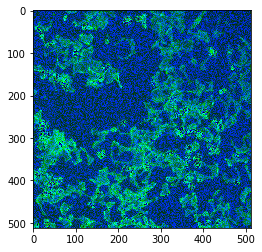

In [62]:
plot_pil(img[0])

torch.Size([512, 512])


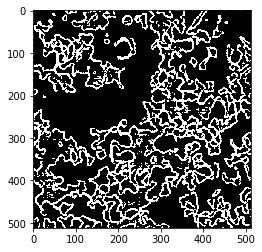

In [63]:
plot_pil(preds[0])

torch.Size([512, 512])


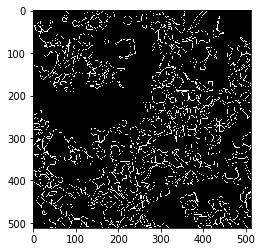

In [64]:
plot_pil(target[0][0])